In [11]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Minimum Variance Portfolio Backtest.

In [12]:
import pandas as pd
from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.features.preprocessor import Preprocessor
from run import Dataset

In [13]:
REBAL_FREQ = "ME"
DATASET = Dataset.SPX_US
ESTIMATION_WINDOW = 365 * 1

In [14]:
experiment_config = DATASET.value()

stocks = tuple(
    pd.read_csv(experiment_config.PATH_OUTPUT / experiment_config.STOCKS_LIST_FILENAME)
    .iloc[:, 0]
    .astype(str)
    .tolist(),
)
experiment_config.ASSET_UNIVERSE = stocks  # type: ignore  # noqa: PGH003

experiment_config.N_LOOKBEHIND_PERIODS = None
experiment_config.REBALANCE_FREQ = REBAL_FREQ

factors = pd.read_csv(experiment_config.PATH_OUTPUT / "factors.csv")
factors["date"] = pd.to_datetime(factors["date"])
factors = factors.set_index("date")
factor_names = tuple(factors.columns.astype(str).tolist())
experiment_config.FACTORS = factor_names

prices = [stock + "_Price" for stock in list(stocks)]
preprocessor = Preprocessor(
    exclude_names=[
        *list(stocks),
        experiment_config.RF_NAME,
        *experiment_config.HEDGING_ASSETS,
        *factor_names,
        *prices,
    ],
)

trading_config = TradingConfig(
    broker_fee=0.05 / 100,
    bid_ask_spread=0.03 / 100,
    total_exposure=1,
    max_exposure=1,
    min_exposure=0,
    trading_lag_days=1,
)

runner = Runner(
    experiment_config=experiment_config,
    trading_config=trading_config,
    verbose=True,
)

Backtest on 2000-12-29 00:00:00 to 2023-12-18 00:00:00
Num Train Iterations: 277
Num OOS Daily Points: 5778


In [15]:
ESTIMATOR = CovEstimators.DNK.value(shrinkage_type="linear", window_size=365 * 20)

strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Computing Weights: 100%|██████████| 277/277 [02:09<00:00,  2.13it/s]


StrategyStatistics:
* final_nav = 6.227749
* geom_avg_total_r = 0.103805
* geom_avg_xs_r = 0.096540
* std_xs_r = 0.138979
* min_xs_r = -0.087828
* max_xs_r = 0.086192
* skew = -0.182156
* kurtosis = 19.704190
* max_dd = -0.300552
* sharpe = 0.694633
* alpha_buy_hold = 0.032948
* tracking_error_buy_hold = 0.129295
* ir_buy_hold = 0.254827
* factor_loadings = {'low_risk': 0.41579811137196665, 'momentum': -0.010809931729685428, 'quality': 0.012283501291444406, 'size': 0.06791836421602178, 'value': -0.1199891894595186, 'spx': 0.7009520425393967}
* alpha_benchmark = 0.036259
* alpha_benchmark_pvalue = 0.024417
* tracking_error_benchmark = 0.068039
* ir_benchmark = 0.532914
* ttest_pval = 0.392284
* levene_pval = 0.000000
* timing_ability_coef = -0.041103
* timing_ability_pval = 0.001181

In [16]:
result.std_xs_r

np.float64(0.13897942302697314)

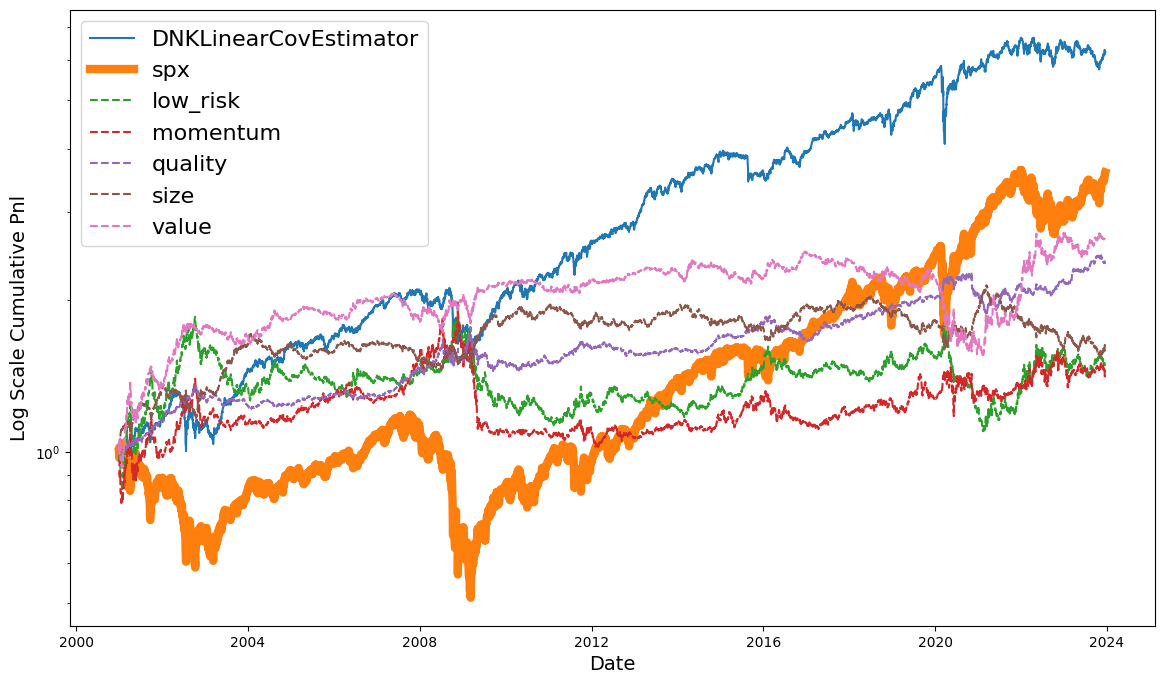

In [17]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

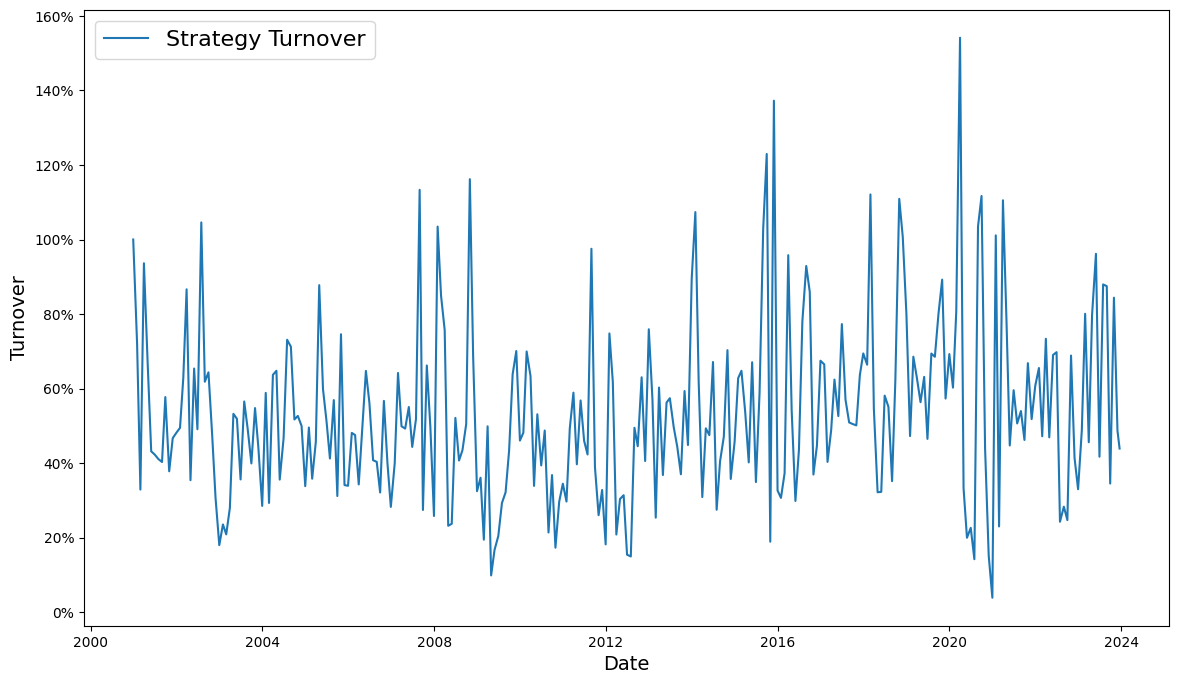

In [18]:
runner.plot_turnover()

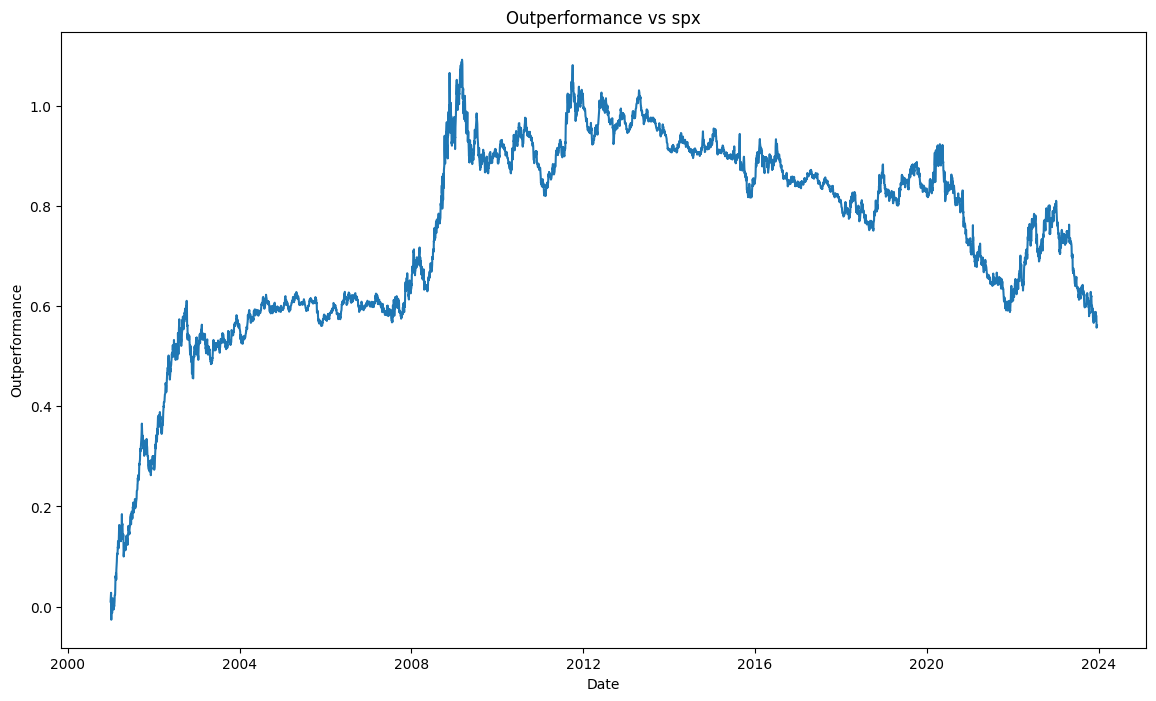

In [19]:
runner.plot_outperformance(mkt_only=True)

In [20]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

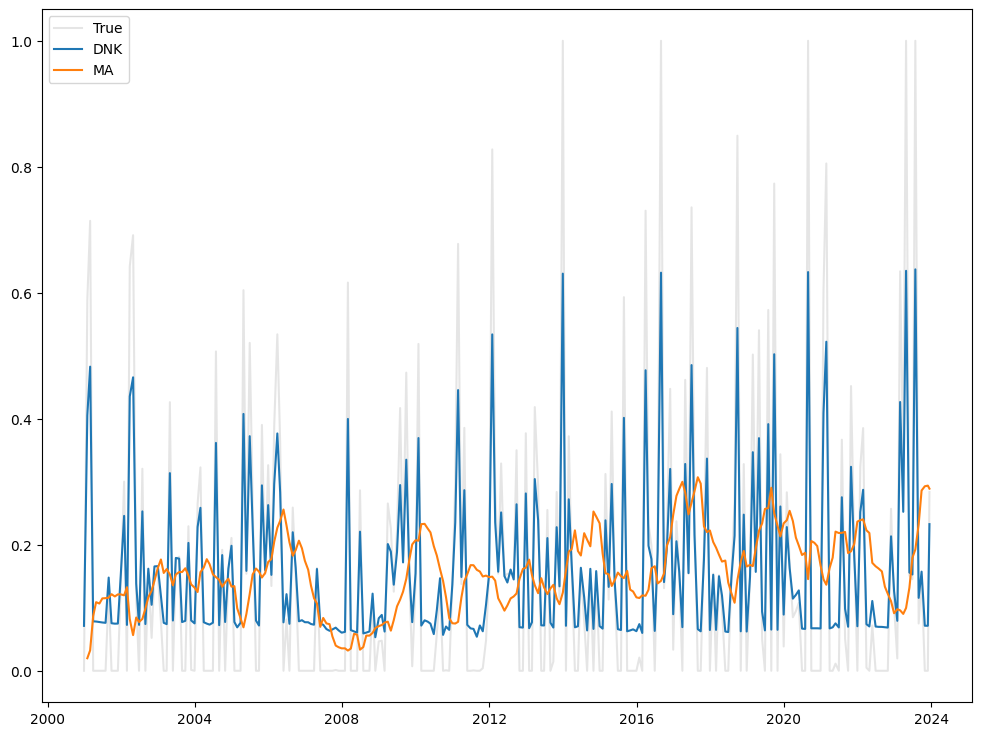

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

pred = ESTIMATOR.predictions

targets = runner.targets.loc[pred.index, "target"]
ma = runner.features.loc[pred.index, "target_rolling_mean"].shift(1)

plt.plot(
    targets.index,
    targets.to_numpy(),
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(pred.index, pred.to_numpy(), label="DNK")
plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(targets, pred)

0.0737266615956881